In [1]:
import numpy as np 
from numpy import random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime as dt
import os
from sklearn import *


In [2]:
def sigmoid(z):
    return((1 + np.exp(-z))**(-1))

def regularize(m):
    return(m/np.sum(m))

def ReLU(Z):
    return np.maximum(Z, 0)

def weighted_cross_entropy(y, p, m):
    return -sum(m*(y*np.log(p) + (1-y)*np.log(1-p)))

def get_dAdZ1(A, Z1):
    rows, columns = A.shape 
    d = np.zeros((rows, columns, rows, columns))
    for r in range(rows):
        for c in range(columns):
            d[r,c,r,c] = Z1[r, c]
    return np.maximum(d, 0)

def get_dZ1dB1(Z1, B1):
    rows, columns = Z1.shape 
    d = np.zeros((rows, columns, rows, columns))
    for r in range(rows):
        for c in range(columns):
            d[r,c,r,c] = 1
    return d

def get_dZ1dW1(Z1, X):
    rows, columns = Z1.shape 
    features = X.shape[1]
    d = np.zeros((rows, columns, features, columns))
    for r in range(rows):
        for c in range(columns):
            d[r,c,:,c] = X[r,:]
    return d

def pFromX(X, seed = 1103):
    npr.seed(seed)
    T = X @ npr.randn(D, 7)/1.5
    T += sigmoid(T)
    T -= np.exp(T/5)
    T = T @ npr.randn(T.shape[1], 4)/1.5
    T -= np.tile(T.mean(0), T.shape[0]).reshape(T.shape)
    T /= np.tile(T.std(0), T.shape[0]).reshape(T.shape)/(10)
    p = sigmoid(T.mean(1) - T.mean())
    return p

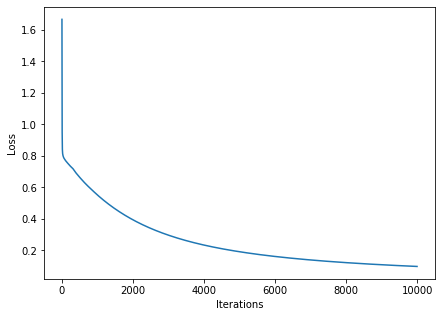

In [3]:
class NN():
    
    def __init__(self, name = None):
        self.name = name
        
    def generate_data(self, N, D, pFromX, seed = 1103):
        npr.seed(seed)
        self.N, self.D = N, D
        self.m = np.repeat(1/N, N)
        mu = npr.randn(D) # means
        Sigma = np.eye(D) # covariance
        self.X = npr.multivariate_normal(mu, Sigma, size = N) # get data (X)
        self.latent_p = pFromX(self.X) # get latent P
        self.y = npr.binomial(1, self.latent_p, N) # true outcome values
      
    def add_data(self, X, pFromX, seed = 1103):
        npr.seed(seed)
        self.N, self.D = X.shape
        self.m = np.repeat(1/self.N, self.N)
        self.X = X
        self.latent_p = pFromX(X)
        self.y = npr.binomial(1, self.latent_p, N)
        
    def get_output(self):
        self.Z1 = (self.X @ self.W1) + self.B1
        self.A = ReLU(self.Z1)
        self.z2 = (self.A @ self.w2) + self.b2
        self.p = sigmoid(self.z2)
        self.L = weighted_cross_entropy(self.y, self.p, self.m)
        
    def get_derivatives(self):
        # partials
        dpdz2 = np.diag(sigmoid(self.z2)*(1-sigmoid(self.z2))) # (N, N)
        dz2db2 = np.eye(self.N) # (N, N)
        dz2dw2 = self.A # (N, h)
        dz2dA = np.tensordot(np.eye(self.N), self.w2, 0) # (N, N, h)
        dAdZ1 = get_dAdZ1(self.A, self.Z1) # (N, h, N, h)
        dZ1dB1 = get_dZ1dB1(self.Z1, self.B1) # (N, h, N, h)
        dZ1dW1 = get_dZ1dW1(self.Z1, self.X) # (N, h, D, h)

        # full derivatives of loss function
        self.dLdp = self.m*(-self.y/self.p + (1-self.y)/(1-self.p)) # N
        self.dLdz2 = self.dLdp @ dpdz2 # N
        self.dLdb2 = self.dLdz2 @ dz2db2 # N
        self.dLdw2 = self.dLdz2 @ dz2dw2 # h
        self.dLdA = np.tensordot(self.dLdz2, dz2dA, 1) # (N, h)
        self.dLdZ1 = ReLU(self.dLdA) * (self.Z1 > 0) # (N, h)
        self.dLdB1 = self.dLdZ1.sum(0) # h
        self.dLdW1 = self.X.T @ self.dLdZ1 # (D, h)
        
    def update_parameters(self):
        self.W1 -= self.lr*self.dLdW1
        self.B1 -= self.lr*self.dLdB1
        self.w2 -= self.lr*self.dLdw2
        self.b2 -= self.lr*self.dLdb2
        
    def train(self, h, lr, n_iters):
        # add parameters
        self.h = h 
        self.lr = lr
        self.n_iters = n_iters 
        
        # instantiate parameters randomly and get outputs
        self.W1 = npr.randn(self.D*self.h).reshape((self.D, self.h))
        self.B1 = np.tile(npr.randn(self.h), self.N).reshape((self.N, self.h))
        self.w2 = npr.randn(self.h)
        self.b2 = npr.randn(self.N) 
        self.get_output()
        
        # loop
        self.losses = []
        for i in range(n_iters):
            self.get_derivatives()
            self.update_parameters()
            self.get_output()
            self.losses.append(self.L)
            
    def plot_losses(self):
        fig, ax = plt.subplots(figsize = (7, 5))
        sns.lineplot(np.arange(self.n_iters), self.losses)
        ax.set(xlabel = 'Iterations', ylabel = 'Loss');
        

N, D = 100, 5 
h, lr, n_iters = 3, 0.1, 10**4
nn = NN()
nn.generate_data(N, D, pFromX)
nn.train(h, lr, n_iters)
nn.plot_losses()

In [4]:
np.mean(nn.p[nn.y == 1]) - np.mean(nn.p[nn.y == 0])

0.8146046830697787